In [1]:
!pip install openai
!pip install datasets

In [2]:
from datasets import load_dataset
import time
import json

dataset = load_dataset("art")

Found cached dataset parquet (/Users/jacobnelson/.cache/huggingface/datasets/parquet/anli-8a11dd669a7ff248/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
from openai import OpenAI

client = OpenAI()

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [4]:
results = dict()
results["Random"] = 0.50
results["ACR Paper (2019)"] = 0.689
results["CompassMTL Paper (2022)"] = 0.9280
results["Human Testing"] = 0.9290

In [5]:
test_num = 200

In [6]:
system_prompt = """I’ll provide an incomplete set of observations, O1 and O2. I’ll also provide two hypotheses, H1 and H2.
Given this information, select whether H1 or H2 explains the incomplete set of observations better. If H1, return solely ‘1’. If H1, return solely ‘2’."""

In [7]:
total_seen = 0
total_correct = 0

for i in range(test_num):
    row_num = i
    user_prompt = f"""O1={dataset["validation"][row_num]["observation_1"]}
    O2={dataset["validation"][row_num]["observation_2"]}
    H1={dataset["validation"][row_num]["hypothesis_1"]}
    H2={dataset["validation"][row_num]["hypothesis_2"]}
    """
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
      ]
    )
    
    message = completion.choices[0].message.content
    if (message == 'H1' or message == 'H2'):
        correct_answer = dataset["validation"][row_num]["label"]
        if (int(message[1]) == correct_answer):
            total_correct += 1
        total_seen += 1
        
    time.sleep(1)

results["GPT-3.5-turbo"] = total_correct / total_seen

In [8]:
results

{'Random': 0.5,
 'ACR Paper (2019)': 0.689,
 'CompassMTL Paper (2022)': 0.928,
 'Human Testing': 0.929,
 'GPT-3.5-turbo': 0.6878306878306878}

In [9]:
total_seen = 0
total_correct = 0

for i in range(test_num):
    row_num = i
    
    user_prompt = f"""O1={dataset["validation"][row_num]["observation_1"]}
    O2={dataset["validation"][row_num]["observation_2"]}
    H1={dataset["validation"][row_num]["hypothesis_1"]}
    H2={dataset["validation"][row_num]["hypothesis_2"]}
    """
    
    completion = client.chat.completions.create(
      model="gpt-4",
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
      ]
    )
    
    message = completion.choices[0].message.content
    if (message == '1' or message == '2'):
        correct_answer = dataset["validation"][row_num]["label"]
        if (int(message[0]) == correct_answer):
            total_correct += 1
        total_seen += 1
        
    time.sleep(1)

results["GPT-4"] = total_correct / total_seen

In [10]:
results

{'Random': 0.5,
 'ACR Paper (2019)': 0.689,
 'CompassMTL Paper (2022)': 0.928,
 'Human Testing': 0.929,
 'GPT-3.5-turbo': 0.6878306878306878,
 'GPT-4': 0.8585858585858586}

In [11]:
with open('validate.json', 'r') as file:
    data = json.load(file)


In [12]:
total_seen = 0
total_correct = 0   
for i in range(len(data)):
    row_num = i
    
    user_prompt = f"""
    O1={data[row_num]["observation_1"]}
    O2={data[row_num]["observation_2"]}
    H1={data[row_num]["hypothesis_1"]}
    H2={data[row_num]["hypothesis_2"]}
    """
    
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
      ]
    )
    
    message = completion.choices[0].message.content
    print(message)
    
    if (message == 'H1' or message == 'H2'):
        correct_answer = data[row_num]["label"]
        if (int(message[1]) == correct_answer):
            total_correct += 1
        total_seen += 1
results["Non-public data GPT-3.5-turbo"] = total_correct / total_seen

H1
H2
H2
H2
Hypothesis 1 (H1) explains the incomplete set of observations better:

1
H2
H1
H2
H1
H2


In [13]:
total_seen = 0
total_correct = 0   
for i in range(len(data)):
    row_num = i
    
    user_prompt = f"""
    O1={data[row_num]["observation_1"]}
    O2={data[row_num]["observation_2"]}
    H1={data[row_num]["hypothesis_1"]}
    H2={data[row_num]["hypothesis_2"]}
    """
    
    completion = client.chat.completions.create(
      model="gpt-4",
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
      ]
    )
    
    message = completion.choices[0].message.content
    print(message)
    
    
    if (message == '1' or message == '2'):
        correct_answer = data[row_num]["label"]
        if (int(message[0]) == correct_answer):
            total_correct += 1
        total_seen += 1
        
results["Non-public data GPT-4"] = total_correct / total_seen

1
2
2
2
1
2
1
2
1
2


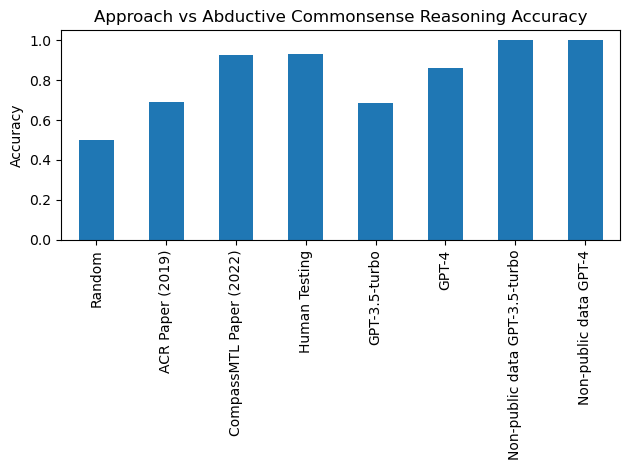

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
result_series = pd.Series(results)
fig, ax = plt.subplots()
result_series.plot.bar(ax=ax)
ax.set_ylabel('Accuracy')
plt.title('Approach vs Abductive Commonsense Reasoning Accuracy')
plt.tight_layout()
plt.savefig('plot.png')



In [16]:
with open('results.json', 'w') as json_file:
    json.dump(results, json_file)